# Predictive Lead Scoring 

### Who Is This For?
Your sales development reps, or SDRs, will use the lead score to prioritize the deluge of leads in your CRM.

Right now, they are using their internal heuristics to decide who to reach out to, but this has led to missed opportunities and inconsistent results from one person to the next.

There are far too few SDRs right now for the number of leads. Their typical workflow is scanning a large list, looking for something that stands out, and then emailing those leads with a custom message to get them to respond. As a result, they are stressed, overwhelmed, and constantly worried that they've missed something critical.

### How Will They Use the Lead Scores?
A good lead scoring model will be something that the SDRs can use as a quick heuristic. They will use it by sorting their inbound list by the score in descending order. This ranking will help them better separate good leads from bad ones and give them more confidence that they haven't missed anything.

### What Data to Use for Lead Scoring?
You decide to interview the SDRs to understand their heuristics better. They tell you the highest signal pieces of data they use are the size of the company (number of employees and revenue), the industry, the role, and whether they've engaged with us through marketing efforts such as a conference or a whitepaper.

### How Will You Know if Your Lead Scoring Model Works?
Your model will run daily to calculate scores for all inbound leads, so you decide to save the historical scores. Then, in a few weeks, you'll run an analysis to see the average score of leads that the SDR team reached out to daily. You'll also compare the conversion rate of all leads against your predicted score to help you understand which SDRs are using your scores.

---
Dataset: For this example, I created some fake data representative of some leads that a B2B SaaS company might have captured from various sources. 

In [1]:
import pandas as pd

In [2]:
filename = "data/leads.csv"
df = pd.read_csv(filename, index_col=0)
print(f"Dataframe shape: {df.shape}")
df.sample(10)

Dataframe shape: (10000, 7)


,name,title,lead_source,industry,employees,country,converted
,,,,,,,
4971,Madeline Lee,Data Scientist,Webinar,Consumer Staples,12805,SZ,False
1601,Sharon Cobb,CEO,Sign-up,Consumer Staples,14005,KH,False
5410,Anthony Berry,VP Engineering,Sign-up,Consumer Staples,430,KP,False
3194,David Gaines,VP Marketing,Sign-up,Software & Services,105,SE,False
8850,Kenneth Hayes,Owner,Sign-up,Software & Services,4455,CR,False
8465,Amanda Morales,Product Manager,In-Person Event,Software & Services,2455,KI,True
8631,Mr. Albert Williams,CEO,In-Person Event,Software & Services,6455,ZA,False
2455,Rebecca Smith,VP Marketing,Webinar,Commercial & Professional Services,12880,MD,False
3660,James Byrd,Data Analyst,Sign-up,Consumer Staples,5680,GN,False


Our data includes the names and titles of people who might be interested in buying our product. We captured where the lead was sourced from, such as a webinar or application sign-up. We also have information on their company, such as the industry, the number of employees, and country. We also have a flag for whether or not this lead converted.


### Hand-crafted lead scoring

In our first example, we'll take a look at just two factors, lead source and title indicators to see what a simple baseline model can do for us. Let's pretend we asked our SDR reps and they said that those with Engineering in their title and with Lead Source Sgned-up are the best leads. 

In [3]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

le = LabelEncoder()
y = le.fit_transform(df.converted)
X = pd.get_dummies(df.drop(['converted', 'name', 'country'], axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
# Let's build a hand-crafted model and return our scores

def hand_crafted_predictor(df):
    if ('engineer' in df['title'].lower()) and (df.lead_source == 'Sign-up'):
        return 1
    return 0

pred_hand_crafted = df.apply(hand_crafted_predictor, axis=1)

print('Balanced Accuracy', round(balanced_accuracy_score(y, pred_hand_crafted) * 100, 2))
print('F1 Score', round(f1_score(y, pred_hand_crafted) * 100, 2))
print('Precision', round(precision_score(y, pred_hand_crafted) * 100, 2))
print('Recall', round(recall_score(y, pred_hand_crafted) * 100, 2))

Balanced Accuracy 51.82
F1 Score 18.1
Precision 23.45
Recall 14.74


Our accuracy is not much better than chance. Still, it's good to have a simple baseline to measure yourself against.

In [5]:
# Train a decision tree

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_param = {'dt__criterion':['gini','entropy'],'dt__max_depth':[5, 10, 15, 25, 35]}

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("dt", DecisionTreeClassifier())]
)

gs_dt = GridSearchCV(clf,
                      param_grid=tree_param,
                      scoring="f1",
                      cv=2)
gs_dt_scores = cross_val_score(gs_dt, X=X_train, y=y_train, cv=5, scoring='f1', n_jobs=-1)
              
gs_dt.fit(X_train,y_train)


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dt', DecisionTreeClassifier())]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': [5, 10, 15, 25, 35]},
             scoring='f1')

In [6]:
print(gs_dt.best_params_)
print(gs_dt.score(X_train, y_train))

{'dt__criterion': 'gini', 'dt__max_depth': 25}
0.9379157427937916


In [7]:
# Get our test scores on the decision tree
pred_dt=gs_dt.predict(X_test)

print('Balanced Accuracy', round(balanced_accuracy_score(y_test, pred_dt) * 100, 2))
print('F1 Score', round(f1_score(y_test, pred_dt) * 100, 2))
print('Precision', round(precision_score(y_test, pred_dt) * 100, 2))
print('Recall', round(recall_score(y_test, pred_dt) * 100, 2)) 

Balanced Accuracy 58.93
F1 Score 32.69
Precision 33.49
Recall 31.94


Our F1 score increased from 18 to 32, our precision increased from 23% to 33% and our Recall increased from 14% to 31%. Seeing improvements in both precision and recall is particularly exciting since it means we aren’t just trading one off against the other, but seeing material improvements in the model performance.

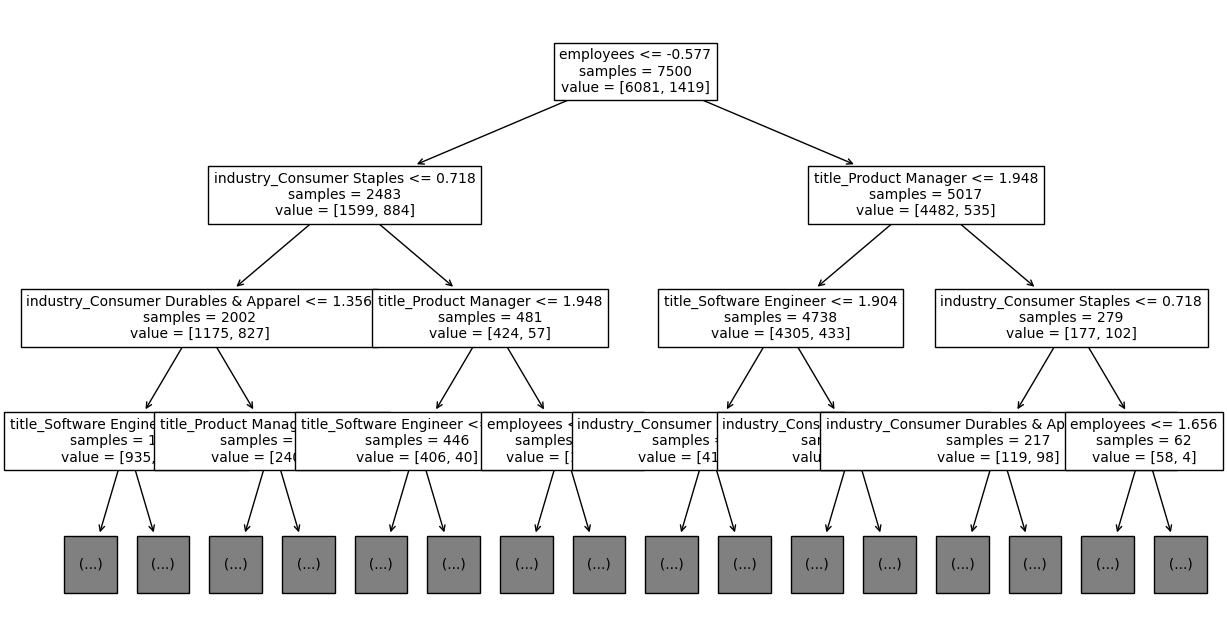

In [8]:
from sklearn import tree
import matplotlib.pyplot as plt
dt = gs_dt.best_estimator_.named_steps['dt']
plt.figure(figsize=[15, 8])

tree.plot_tree(dt, max_depth=3, fontsize=10, impurity=False, feature_names=gs_dt.best_estimator_.feature_names_in_)
plt.show()

In [9]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'rf__n_estimators': [4, 5, 6, 7, 8, 9],
    'rf__max_depth' : [30, 40, 50, 60, 70, 80],
    'rf__criterion' :['gini']
}
clf = Pipeline(
    steps=[("rf", RandomForestClassifier())]
)


gs_rf = GridSearchCV(clf,
                      param_grid=param_grid,
                      scoring='f1',
                      cv=2)

gs_rf_scores = cross_val_score(gs_rf, X=X_train, y=y_train, cv=5, scoring='f1', n_jobs=-1)
              
gs_rf.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             param_grid={'rf__criterion': ['gini'],
                         'rf__max_depth': [30, 40, 50, 60, 70, 80],
                         'rf__n_estimators': [4, 5, 6, 7, 8, 9]},
             scoring='f1')

In [10]:
print(gs_rf.best_params_)
print(gs_rf.score(X_train, y_train))

{'rf__criterion': 'gini', 'rf__max_depth': 40, 'rf__n_estimators': 7}
0.920967159870083


In [11]:
pred_rf=gs_rf.predict(X_test)

print('Balanced Accuracy', round(balanced_accuracy_score(y_test, pred_rf) * 100, 2))
print('F1 Score', round(f1_score(y_test, pred_rf) * 100, 2))
print('Precision', round(precision_score(y_test, pred_rf) * 100, 2))
print('Recall', round(recall_score(y_test, pred_rf) * 100, 2))

Balanced Accuracy 58.86
F1 Score 32.34
Precision 35.43
Recall 29.74


We can see some marginal improvements in performance but at a greater cost of interpretability. In a Random Forest model, we don’t have access to exactly how a decision is made, but we can plot how important various variables are to the overall model.

By plotting a feature importance plot, we see how important the number of employees is to the quality of our leads. This matches our intuition from the decision tree plot but is also interesting to note that this wasn’t the main feature our SDRs mentioned when discussing what they think is important.

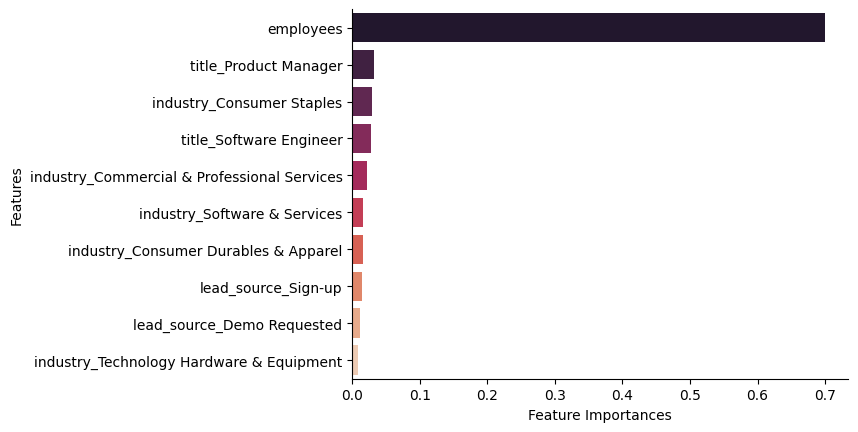

In [12]:
import seaborn as sns
importances= gs_rf.best_estimator_.named_steps['rf'].feature_importances_
feature_importances= pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10], palette="rocket", hue=feature_importances.index[0:10])
sns.despine()
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred_rf)

array([[1800,  246],
       [ 319,  135]])

### Assessing Model Performance
There are two ways we can be wrong: we either rank someone highly who isn't going to convert, or we categorize someone low who would've converted. Which is the greater sin?

The cost of reaching out to someone who doesn't convert is much lower than the cost of not reaching out to someone who would've converted! So in our model, we might want to optimize for fewer False Negatives over False Positives.

Precision is the level of confidence we can have in our predictions. Precision is the ratio of True Positive cases over all Predicted Positive cases. Precision helps our SDRs gain confidence in our predictions. If we say that we have 75% precision in our model, that means three people will convert for every four that we say you should contact. That's pretty great!

Recall is the lost opportunity metric. Of all the people who were likely to convert, how many of them did we predict would convert? Again, we don't want this number to be too low; otherwise, it means there will be many hidden gems in our leads that would become customers.

How can we balance Precision and Recall? We can use the F1 score, which balances these metrics by calculating the harmonic mean between the two.

Our Random Forest model has the highest F1 score, and we can see it does marginally better on Precision and Recall than our Decision Tree.